In [1]:
%%capture
import os
import numpy as np
import pandas as pd
import cv2
from tqdm.notebook import tqdm_notebook
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

2024-05-03 04:27:52.361759: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-03 04:27:52.361856: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-03 04:27:52.486507: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
input_dir = '/kaggle/input'
output_dir = '/kaggle/working'
working_dir = '/kaggle/working'

In [3]:
%%bash
ls /kaggle/input
echo
real_img_count=`ls /kaggle/input/ffhq-face-data-set/thumbnails128x128 | wc -l`
echo "Real image count: $real_img_count" 
fake_img_count=`ls /kaggle/input/person-face-dataset-thispersondoesnotexist/thispersondoesnotexist.10k | wc -l`
echo "Fake image count: $fake_img_count"

ffhq-face-data-set
person-face-dataset-thispersondoesnotexist

Real image count: 70000
Fake image count: 10000


# Data Preprocessing

In [4]:
real_img_dir = f"{input_dir}/ffhq-face-data-set/thumbnails128x128"
fake_img_dir = f"{input_dir}/person-face-dataset-thispersondoesnotexist/thispersondoesnotexist.10k"

input_shape = (128,128,3)

In [5]:
# processing data
X = []
Y = []

for img in tqdm_notebook(os.listdir(real_img_dir)[:3000]):
    X.append(img_to_array(load_img(f"{real_img_dir}/{img}", target_size=input_shape)) / 255.0)
    Y.append(0)

for img in tqdm_notebook(os.listdir(fake_img_dir)[:3000]):
    X.append(img_to_array(load_img(f"{fake_img_dir}/{img}", target_size=input_shape)) / 255.0)
    Y.append(1)


# normalization
X = np.array(X)
X = X.reshape(-1, 128, 128, 3)
Y = to_categorical(Y, 2)
# Y = np.array(Y)

# saving processed data arrays
os.chdir(output_dir)
np.save('X.npy',X)
np.save('Y.npy',Y)

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

In [6]:
# load saved data files
os.chdir(working_dir)
X = np.load('X.npy')
Y = np.load('Y.npy')

# train test split
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size = 0.2, random_state=5)

# info
print(f"\ndata shape: {X.shape}; labels shape: {Y.shape}")
print(f"X_train shape: {X_train.shape}\nY_train shape: {Y_train.shape}")
print(f"X_val shape: {X_val.shape}\nY_val shape: {Y_val.shape}")


data shape: (6000, 128, 128, 3); labels shape: (6000, 2)
X_train shape: (4800, 128, 128, 3)
Y_train shape: (4800, 2)
X_val shape: (1200, 128, 128, 3)
Y_val shape: (1200, 2)


# Model Creation and Training

In [7]:
from tensorflow.keras.applications import InceptionResNetV2,InceptionV3
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten, Input, InputLayer, GlobalAveragePooling2D, Activation, MaxPool2D
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from keras import backend as K

# transfer_model = InceptionV3(include_top=False, weights='imagenet', input_shape=input_shape, classes=2)
# transfer_model.trainable = True
# model = Sequential()
# model.add(transfer_model)
# model.add(GlobalAveragePooling2D(name='avg_2d_pool'))
# model.add(Flatten(name='flatten_layer'))

# model.add(Dense(100,activation='relu))
# model.add(Dense(units=2, activation='softmax'))
# model.compile(loss='binary_crossentropy',
#               optimizer=optimizers.Adam(learning_rate=1e-5, beta_1=0.9, beta_2=0.999),
#               metrics=['accuracy'])

# model.summary()

In [8]:
# Not using transfer learning
# made our own model!

inputs=Input(shape=input_shape)
x = Conv2D(64,5,padding='same')(inputs)
x = Activation(activation='relu')(x)
x = MaxPool2D(strides=(2,2))(x)
x = Conv2D(64,5,padding='same')(x)
x = Activation(activation='relu')(x)
x = MaxPool2D(strides=(2,2))(x)
x = Conv2D(64,5,padding='same')(x)
x = Activation(activation='relu')(x)
x = MaxPool2D(strides=(2,2))(x)

 #Decreasing Filters and MAxPool Layers
x = Conv2D(32,3,padding='same',dilation_rate=2)(x)
x = Activation(activation='relu')(x)
# x = BatchNormalization()(x)
x = MaxPool2D(strides=(2,2))(x)
x = Conv2D(16,3,padding='same',dilation_rate=2)(x)
x = Activation(activation='relu')(x)
x = MaxPool2D(strides=(2,2))(x)
# x = BatchNormalization()(x)
x = Conv2D(16,3,padding='same',dilation_rate=2)(x)
x = Activation(activation='relu')(x)
x = MaxPool2D(strides=(2,2))(x)

 #Dense Layers
x = GlobalAveragePooling2D()(x)
x = Flatten()(x)
x = Dense(400)(x)
x = Dropout(0.5)(x)
x = Activation(activation='relu')(x)
x = Dense(512)(x)
x = Dropout(0.5)(x)
x = Activation(activation='relu')(x)
x = Dense(400)(x)
x = Dropout(0.5)(x)
x = Activation(activation='relu')(x)
x = Dense(2)(x)

#Output
out = Activation(activation='sigmoid')(x)

# final model:
model = Model(inputs,out,name='BaseModel')
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.Adam(learning_rate=1e-5, beta_1=0.9, beta_2=0.999),
              metrics=['accuracy'])

model.summary()

Model: "BaseModel"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 128, 128, 64)   │         4,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 64)     │       102,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 64)     │       102,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 8, 8, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 8, 8, 16)       │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 8, 8, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 4, 4, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 4, 4, 16)       │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 4, 4, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 2, 2, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 16)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 400)            │         6,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 400)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_6 (Activation)       │ (None, 400)            │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 653,314 (2.49 MB)

 Trainable params: 653,314 (2.49 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
# es = EarlyStopping(monitor='val_loss', min_delta=0, patience=2, verbose=1, mode='auto')
checkpoint_callback = ModelCheckpoint(filepath='/kaggle/working/deepfake.keras', monitor='val_accuracy', save_best_only=True, verbose=1)


train_logs = model.fit(X_train, Y_train, batch_size=32, epochs=100, 
                    validation_data = (X_val, Y_val), verbose = 1, callbacks=[checkpoint_callback])

Epoch 1/100
 10/150 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.4713 - loss: 0.6935

I0000 00:00:1714710646.541668      79 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


148/150 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.4989 - loss: 0.6932
Epoch 1: val_accuracy improved from -inf to 0.49417, saving model to /kaggle/working/deepfake.keras
150/150 ━━━━━━━━━━━━━━━━━━━━ 19s 37ms/step - accuracy: 0.4990 - loss: 0.6932 - val_accuracy: 0.4942 - val_loss: 0.6931
Epoch 2/100
148/150 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.5165 - loss: 0.6930
Epoch 2: val_accuracy did not improve from 0.49417
150/150 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.5162 - loss: 0.6930 - val_accuracy: 0.4942 - val_loss: 0.6931
Epoch 3/100
148/150 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.4958 - loss: 0.6931
Epoch 3: val_accuracy did not improve from 0.49417
150/150 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.4959 - loss: 0.6931 - val_accuracy: 0.4942 - val_loss: 0.6931
Epoch 4/100
148/150 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.5095 - loss: 0.6931
Epoch 4: val_accuracy did not improve from 0.49417
150/150 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy

In [10]:
K.clear_session()

# Performance Analysis

## Training visualization

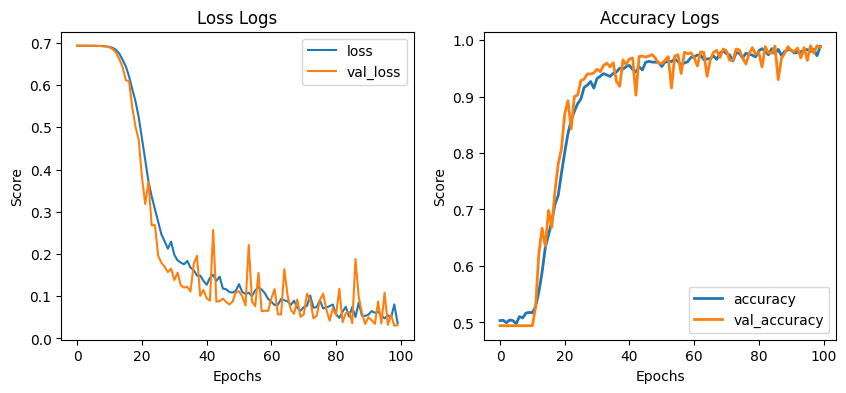

In [11]:
# visualization
import matplotlib.pyplot as plt
import seaborn as sn


fig, axs = plt.subplots(1, 2, figsize=(10, 4))

axs[0].plot(train_logs.history['loss'], label='loss')
axs[0].plot(train_logs.history['val_loss'], label='val_loss')
axs[0].legend()
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Score')
axs[0].set_title('Loss Logs')

axs[1].plot(train_logs.history['accuracy'], label='accuracy', linewidth=2)
axs[1].plot(train_logs.history['val_accuracy'], label='val_accuracy', linewidth=2)
axs[1].legend()
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Score')
axs[1].set_title('Accuracy Logs')

plt.show()

In [12]:
best_model = load_model('/kaggle/working/deepfake.keras')

## Performance Metrics

38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
Accuracy Score: 0.99
Recall Score: 0.98851
Precision Score: 0.99176

True positive =  602
False positive =  7
False negative =  5
True negative =  586




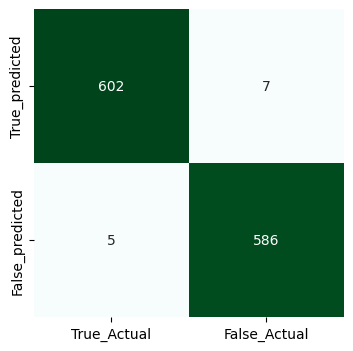

In [13]:
# checking metrics: Accuracy, Reacall, Precision
from sklearn.metrics import precision_score, recall_score, accuracy_score, confusion_matrix
pred = best_model.predict(X_val).round()

predicted = [np.argmax(p) for p in pred]
actual = [np.argmax(p) for p in Y_val]

print(f"Accuracy Score: {accuracy_score(predicted,actual).round(5)}")
print(f"Recall Score: {recall_score(predicted,actual).round(5)}")
print(f"Precision Score: {precision_score(predicted,actual).round(5)}\n")


def print_confusion_matrix(y_true, y_pred):
    cm=confusion_matrix(y_true,y_pred)
    cm[0][0],cm[1][1]=cm[1][1],cm[0][0]
    print('True positive = ', cm[0][0])
    print('False positive = ', cm[0][1])
    print('False negative = ', cm[1][0])
    print('True negative = ', cm[1][1])
    print('\n')
    cm=pd.DataFrame(cm,index=['True_predicted','False_predicted'],columns=['True_Actual','False_Actual'])

    plt.subplots(figsize=(4,4))
    sn.heatmap(cm,cmap='BuGn',annot=True, fmt='.0f',cbar=False)
    plt.show()
    
print_confusion_matrix(actual,predicted)

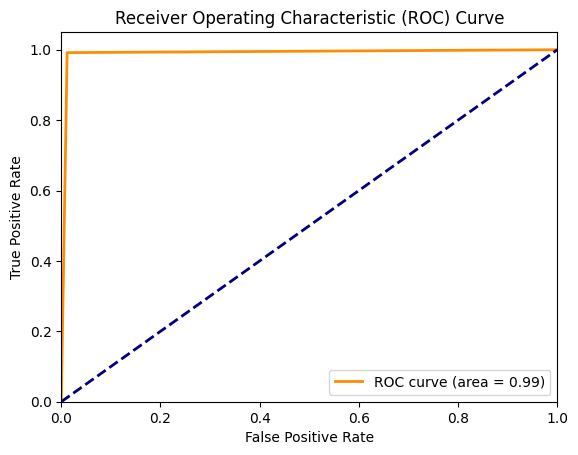

In [14]:
# ROC curve
from sklearn.metrics import roc_curve, auc


def plot_roc(actual,predicted):
    # Calculate the ROC curve
    fpr,tpr,thresholds = roc_curve(actual,predicted)
    # Calculate the area under the ROC curve (AUC)
    roc_auc = auc(fpr, tpr)
    # Plot the ROC curve
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()
    

plot_roc(actual,predicted)


In [15]:
# random image testing
input_arr = img_to_array(load_img('/kaggle/input/ffhq-face-data-set/thumbnails128x128/00001.png', target_size=(128,128,3))) / 255.0
input_arr = np.expand_dims(input_arr, axis=0)
print(input_arr.shape)

np.argmax(best_model.predict(input_arr).round()[0])

(1, 128, 128, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 792ms/step


0

## Save the model

In [16]:
model.save('/kaggle/working/deepfake.h5')
saved_model = tf.keras.models.load_model('/kaggle/working/deepfake.h5')